<a href="https://colab.research.google.com/github/DhimanTarafdar/medical-insurance-cost-prediction-explore/blob/main/Medical_Insurance_Cost_Prediction_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# sklearn preprocessing
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
# Regression models
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.ensemble import VotingRegressor, StackingRegressor
# Metrics
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
# Cross-validation and tuning
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV
from scipy.stats import randint, uniform

import warnings
warnings.filterwarnings("ignore")


In [4]:
# Load the dataset
df = pd.read_csv("/content/medical_insurance.csv")

# Basic information
print("Dataset loaded successfully!")
print(f"Dataset shape: {df.shape}")
print(f"Total rows: {len(df)}")
print(f"Total columns: {len(df.columns)}")
print("\n")
print("Column names:")
print(df.columns.tolist())

Dataset loaded successfully!
Dataset shape: (1338, 7)
Total rows: 1338
Total columns: 7


Column names:
['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'charges']


In [5]:
!pip install ydata-profiling

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.4/400.4 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.7/296.7 kB 20.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 59.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 679.7/679.7 kB 39.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.4/105.4 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.3/43.3 kB 3.0 MB/s eta 0:00:00


In [6]:
from ydata_profiling import ProfileReport

profile = ProfileReport( df , title="Medical Insurance Cost Prediction", explorative = True  )

profile.to_file("ydata.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]


100%|██████████| 7/7 [00:00<00:00, 31.63it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [7]:
# Display first few rows
print("First 5 rows:")
print(df.head())

print("\n")

# Data types and missing values
print("Data types and missing values:")
print(df.info())

print("\n")

# Statistical summary
print("Statistical Summary:")
print(df.describe())

print("\n")

# Missing values count
print("Missing values count:")
print(df.isnull().sum())

print("\n")

# Check for duplicate rows
print(f"Duplicate rows: {df.duplicated().sum()}")

First 5 rows:
   age     sex     bmi  children smoker     region      charges
0   19  female  27.900         0    yes  southwest  16884.92400
1   18    male  33.770         1     no  southeast   1725.55230
2   28    male  33.000         3     no  southeast   4449.46200
3   33    male  22.705         0     no  northwest  21984.47061
4   32    male  28.880         0     no  northwest   3866.85520


Data types and missing values:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB
None


Statistical Summary:
               age   

In [8]:
df[df.duplicated()]


,age,sex,bmi,children,smoker,region,charges
581,19,male,30.59,0,no,northwest,1639.5631


In [9]:
df = df.drop_duplicates()

In [10]:
print("Duplicate rows after removal:", df.duplicated().sum())

Duplicate rows after removal: 0


In [11]:
df.shape

(1337, 7)

In [12]:
# Check unique values in categorical columns

print("Unique values in categorical columns:")

print(f"Sex: {df['sex'].nunique()} unique sex")
print(f"Region: {df['region'].nunique()} unique region")
print(f"Smoker: {df['smoker'].nunique()} unique smoker")


# Check some categorical column values
print("Sex Values:")
print(df['sex'].value_counts())

print("\nRegion Values:")
print(df['region'].value_counts())

print("\nSmoker Values:")
print(df['smoker'].value_counts())



Unique values in categorical columns:
Sex: 2 unique sex
Region: 4 unique region
Smoker: 2 unique smoker
Sex Values:
sex
male      675
female    662
Name: count, dtype: int64

Region Values:
region
southeast    364
southwest    325
northwest    324
northeast    324
Name: count, dtype: int64

Smoker Values:
smoker
no     1063
yes     274
Name: count, dtype: int64


Target variable (charges) distribution:
count     1337.000000
mean     13279.121487
std      12110.359656
min       1121.873900
25%       4746.344000
50%       9386.161300
75%      16657.717450
max      63770.428010
Name: charges, dtype: float64


Correlation with charges:
charges     1.000000
age         0.298308
bmi         0.198401
children    0.067389
Name: charges, dtype: float64




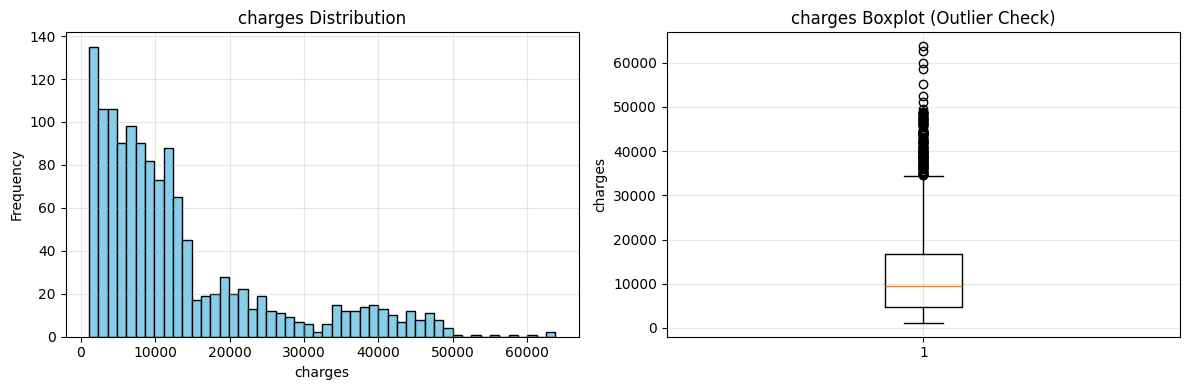



Number of outliers in charges: 139
Percentage of outliers: 10.40%


In [13]:
# Target variable distribution
print("Target variable (charges) distribution:")
print(df['charges'].describe())

print("\n")

# Correlation with target (numeric features only)
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
corr_with_charges= df[numeric_cols].corr()['charges'].sort_values(ascending=False)

print("Correlation with charges:")
print(corr_with_charges)

print("\n")

# Visualize charges distribution
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.hist(df['charges'], bins=50, color='skyblue', edgecolor='black')
plt.xlabel('charges')
plt.ylabel('Frequency')
plt.title('charges Distribution')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.boxplot(df['charges'])
plt.ylabel('charges')
plt.title('charges Boxplot (Outlier Check)')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n")

# Check for outliers
Q1 = df['charges'].quantile(0.25)
Q3 = df['charges'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = df[(df['charges'] < lower_bound) | (df['charges'] > upper_bound)]
print(f"Number of outliers in charges: {len(outliers)}")
print(f"Percentage of outliers: {(len(outliers)/len(df)*100):.2f}%")

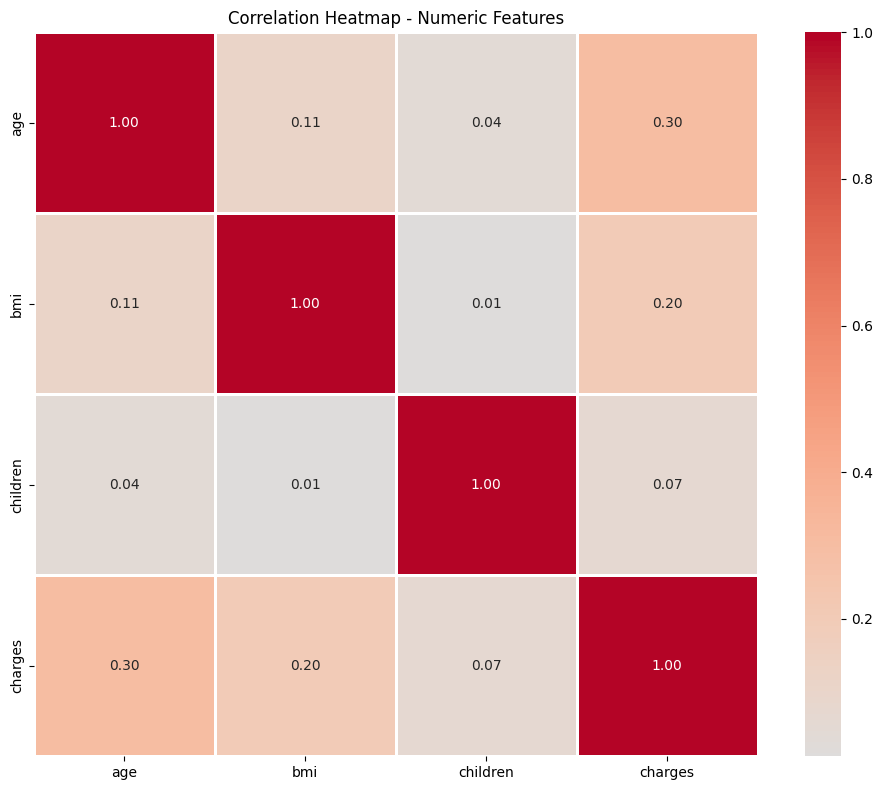



Correlation with charges (sorted):
charges     1.000000
age         0.298308
bmi         0.198401
children    0.067389
Name: charges, dtype: float64


In [14]:
# Select only numeric columns for correlation
numeric_data = df.select_dtypes(include=['int64', 'float64'])

# Create correlation matrix
corr_matrix = numeric_data.corr()

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm',
            center=0, square=True, linewidths=1)
plt.title('Correlation Heatmap - Numeric Features')
plt.tight_layout()
plt.show()

print("\n")

# Show correlation with charges in detail
print("Correlation with charges (sorted):")
print(corr_matrix['charges'].sort_values(ascending=False))

In [15]:
# Separate features and target
X = df.drop('charges', axis=1)
y = df['charges']

print("Features (X):")
print(X.head())

print("\n")

print("Target (y):")
print(y.head())

print("\n")

# Identify numeric and categorical features
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object']).columns.tolist()

print(f"Numeric features ({len(numeric_features)}): {numeric_features}")
print(f"\nCategorical features ({len(categorical_features)}): {categorical_features}")

print("\n")

# Check categorical feature
print("Categorical features - unique values:")
for col in categorical_features:
    print(f"{col}: {X[col].nunique()} unique values")

Features (X):
   age     sex     bmi  children smoker     region
0   19  female  27.900         0    yes  southwest
1   18    male  33.770         1     no  southeast
2   28    male  33.000         3     no  southeast
3   33    male  22.705         0     no  northwest
4   32    male  28.880         0     no  northwest


Target (y):
0    16884.92400
1     1725.55230
2     4449.46200
3    21984.47061
4     3866.85520
Name: charges, dtype: float64


Numeric features (3): ['age', 'bmi', 'children']

Categorical features (3): ['sex', 'smoker', 'region']


Categorical features - unique values:
sex: 2 unique values
smoker: 2 unique values
region: 4 unique values


In [16]:
# Numeric transformer - impute + scale
num_transformer = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ]
)

# Categorical transformer - impute + encode
cat_transformer = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('encoder', OneHotEncoder(handle_unknown='ignore'))
    ]
)

# Combine transformers
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, numeric_features),
        ('cat', cat_transformer, categorical_features)
    ]
)

print("Preprocessing pipeline created!")
print("\nNumeric features will be:")
print("  - Imputed with median")
print("  - Scaled with StandardScaler")

print("\nCategorical features will be:")
print("  - Imputed with most_frequent")
print("  - Encoded with OneHotEncoder")

print("\n")

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Training set size: {X_train.shape[0]} samples")
print(f"Test set size: {X_test.shape[0]} samples")
print(f"Train-test ratio: 80-20")

Preprocessing pipeline created!

Numeric features will be:
  - Imputed with median
  - Scaled with StandardScaler

Categorical features will be:
  - Imputed with most_frequent
  - Encoded with OneHotEncoder


Training set size: 1069 samples
Test set size: 268 samples
Train-test ratio: 80-20


In [17]:
# Define base models
reg_lr = LinearRegression()
reg_rf = RandomForestRegressor(n_estimators=100, random_state=42)
reg_gb = GradientBoostingRegressor(n_estimators=100, random_state=42)
reg_knn = KNeighborsRegressor(n_neighbors=5,weights='distance')

# Voting Regressor - average of all models
voting_reg = VotingRegressor(
    estimators=[
        ('lr', reg_lr),
        ('rf', reg_rf),
        ('gb', reg_gb),
        ('knn', reg_knn),
    ]
)

# Stacking Regressor - meta learner
stacking_reg = StackingRegressor(
    estimators=[
        ('rf', reg_rf),
        ('gb', reg_gb),
        ('knn', reg_knn),

    ],
    final_estimator=Ridge()
)

# Dictionary of all models
models_to_train = {
    'Linear Regression': reg_lr,
    'Random Forest': reg_rf,
    'Gradient Boosting': reg_gb,
    'KNN Regression': reg_knn,
    'Voting Ensemble': voting_reg,
    'Stacking Ensemble': stacking_reg
}

print("6 models defined!")
print("\nModels to train:")
for i, name in enumerate(models_to_train.keys(), 1):
    print(f"  {i}. {name}")

print("\n")

# Train and evaluate all models
results = []

for name, model in models_to_train.items():
    print(f"Training {name}...")

    # Create pipeline
    pipe = Pipeline([
        ('preprocessor', preprocessor),
        ('model', model)
    ])

    # Train
    pipe.fit(X_train, y_train)

    # Predict
    y_pred = pipe.predict(X_test)

    # Evaluate
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)

    results.append({
        'Model': name,
        'R2 Score': r2,
        'RMSE': rmse,
        'MAE': mae
    })

    print(f"{name} trained - R2: {r2:.4f}")

print("\n")

# Create results dataframe
results_df = pd.DataFrame(results).sort_values('R2 Score', ascending=False)

print("MODEL COMPARISON RESULTS:")
print(results_df.to_string(index=False))

6 models defined!

Models to train:
  1. Linear Regression
  2. Random Forest
  3. Gradient Boosting
  4. KNN Regression
  5. Voting Ensemble
  6. Stacking Ensemble


Training Linear Regression...
Linear Regression trained - R2: 0.8069
Training Random Forest...
Random Forest trained - R2: 0.8809
Training Gradient Boosting...
Gradient Boosting trained - R2: 0.9007
Training KNN Regression...
KNN Regression trained - R2: 0.7835
Training Voting Ensemble...
Voting Ensemble trained - R2: 0.8776
Training Stacking Ensemble...
Stacking Ensemble trained - R2: 0.8963


MODEL COMPARISON RESULTS:
            Model  R2 Score        RMSE         MAE
Gradient Boosting  0.900689 4271.894268 2535.062045
Stacking Ensemble  0.896274 4365.818016 2518.107734
    Random Forest  0.880864 4678.877462 2586.373908
  Voting Ensemble  0.877582 4742.888590 2902.296980
Linear Regression  0.806929 5956.342894 4177.045561
   KNN Regression  0.783538 6306.841817 3639.891968


Best Model: Gradient Boosting
R2 Score: 0.9007
RMSE: 4271.89
MAE: 2535.06




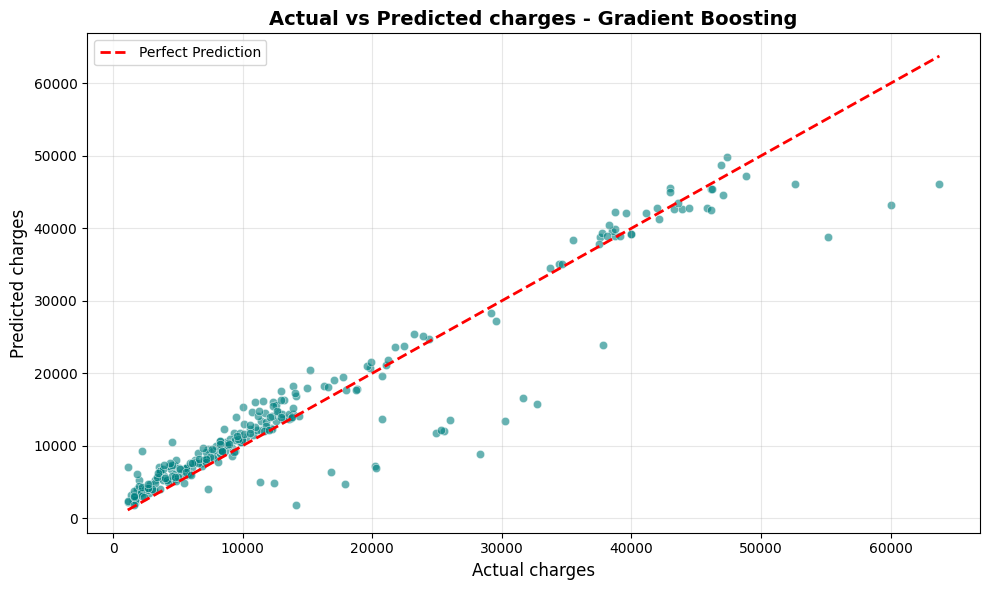



Sample Predictions (First 10):
 Actual charges  Predicted charges  Difference
     8688.85885              10571       -1882
     5708.86700               7016       -1307
    11436.73815              13396       -1959
    38746.35510              38934        -187
     4463.20510               6796       -2333
     9304.70190              11710       -2406
    38511.62830              39660       -1148
     2150.46900               3608       -1457
     7345.72660               9549       -2203
    10264.44210              11264        -999


In [18]:
# Select best model
best_model_name = results_df.iloc[0]['Model']
best_model_obj = models_to_train[best_model_name]

print(f"Best Model: {best_model_name}")
print(f"R2 Score: {results_df.iloc[0]['R2 Score']:.4f}")
print(f"RMSE: {results_df.iloc[0]['RMSE']:.2f}")
print(f"MAE: {results_df.iloc[0]['MAE']:.2f}")

print("\n")

# Train best model on full pipeline
final_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('model', best_model_obj)
])

final_pipe.fit(X_train, y_train)
y_final_pred = final_pipe.predict(X_test)

# Plot Actual vs Predicted
plt.figure(figsize=(10, 6))

sns.scatterplot(x=y_test, y=y_final_pred, alpha=0.6, color='teal')
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         color='red', linestyle='--', linewidth=2, label='Perfect Prediction')

plt.xlabel('Actual charges', fontsize=12)
plt.ylabel('Predicted charges', fontsize=12)
plt.title(f'Actual vs Predicted charges - {best_model_name}', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\n")

# Show some sample predictions
sample_results = pd.DataFrame({
    'Actual charges': y_test.head(10).values,
    'Predicted charges': y_final_pred[:10].astype(int),
    'Difference': (y_test.head(10).values - y_final_pred[:10]).astype(int)
})

print("Sample Predictions (First 10):")
print(sample_results.to_string(index=False))

In [19]:
# Cross-validation with Gradient Boosting
gb_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', GradientBoostingRegressor(n_estimators=100,random_state=42))
])

print("Performing 5-Fold Cross-Validation on Gradient Boosting...")

# 5-fold cross-validation
cv_scores = cross_val_score(
    gb_pipeline,
    X_train,
    y_train,
    cv=5,
    scoring='neg_mean_squared_error'
)

cv_rmse = np.sqrt(-cv_scores)

print("Cross-Validation Results:")
print(f"RMSE scores for each fold: {cv_rmse}")
print(f"\nMean RMSE: {cv_rmse.mean():.2f}")
print(f"Std RMSE: {cv_rmse.std():.2f}")

print("\n")

# Also check R2 with cross-validation
cv_r2_scores = cross_val_score(
    gb_pipeline,
    X_train,
    y_train,
    cv=5,
    scoring='r2'
)

print("R2 scores for each fold:", cv_r2_scores)
print(f"Mean R2: {cv_r2_scores.mean():.4f}")
print(f"Std R2: {cv_r2_scores.std():.4f}")

Performing 5-Fold Cross-Validation on Gradient Boosting...
Cross-Validation Results:
RMSE scores for each fold: [5411.91100723 4540.96470013 4464.57924225 4685.08542233 4869.76460699]

Mean RMSE: 4794.46
Std RMSE: 338.22


R2 scores for each fold: [0.80731296 0.85037916 0.83496726 0.82884084 0.83676945]
Mean R2: 0.8317
Std R2: 0.0141


In [20]:
# Train
gb_pipeline.fit(X_train, y_train)

# Predictions
y_train_pred = gb_pipeline.predict(X_train)
y_test_pred  = gb_pipeline.predict(X_test)


# Metrics
def regression_metrics(y_true, y_pred):
    return {
        "R2": r2_score(y_true, y_pred),
        "RMSE": np.sqrt(mean_squared_error(y_true, y_pred)),
        "MAE": mean_absolute_error(y_true, y_pred)
    }

train_metrics = regression_metrics(y_train, y_train_pred)
test_metrics  = regression_metrics(y_test, y_test_pred)


# Print Results
print("TRAIN PERFORMANCE")
print(f"R2   : {train_metrics['R2']:.4f}")
print(f"RMSE : {train_metrics['RMSE']:.2f}")
print(f"MAE  : {train_metrics['MAE']:.2f}")

print("\nTEST PERFORMANCE")
print(f"R2   : {test_metrics['R2']:.4f}")
print(f"RMSE : {test_metrics['RMSE']:.2f}")
print(f"MAE  : {test_metrics['MAE']:.2f}")


# Overfitting Check
print("\nOVERFITTING CHECK")
print(f"R2 Difference   : {train_metrics['R2'] - test_metrics['R2']:.4f}")
print(f"RMSE Difference: {test_metrics['RMSE'] - train_metrics['RMSE']:.2f}")
print(f"MAE Difference : {test_metrics['MAE'] - train_metrics['MAE']:.2f}")


TRAIN PERFORMANCE
R2   : 0.8932
RMSE : 3823.49
MAE  : 2094.85

TEST PERFORMANCE
R2   : 0.9007
RMSE : 4271.89
MAE  : 2535.06

OVERFITTING CHECK
R2 Difference   : -0.0075
RMSE Difference: 448.41
MAE Difference : 440.21


In [21]:
# Get before tuning metrics FIRST
print("Training baseline model...")
gb_pipeline.fit(X_train, y_train)
y_pred_before = gb_pipeline.predict(X_test)
before_r2 = r2_score(y_test, y_pred_before)
before_rmse = np.sqrt(mean_squared_error(y_test, y_pred_before))
before_mae = mean_absolute_error(y_test, y_pred_before)

print(f"Baseline Performance - R2: {before_r2:.4f}, RMSE: {before_rmse:.2f}, MAE: {before_mae:.2f}")
print("\n")

# Define parameter grid for RandomizedSearchCV
param_dist = {
    'model__n_estimators': randint(100, 300),
    'model__max_depth': [3, 5, 7, 10],
    'model__min_samples_split': randint(2, 10),
    'model__learning_rate': [0.01, 0.05, 0.1, 0.2]
}

print("Starting Hyperparameter Tuning...")

# RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=gb_pipeline,
    param_distributions=param_dist,
    n_iter=20,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    verbose=2,
    random_state=42
)

# Fit
random_search.fit(X_train, y_train)

print("\n")

print("Best Parameters Found:")
print(random_search.best_params_)

print(f"\nBest Cross-Validation RMSE: {-random_search.best_score_:.2f}")

print("\n")

# Evaluate tuned model on test set
y_tuned_pred = random_search.predict(X_test)

tuned_r2 = r2_score(y_test, y_tuned_pred)
tuned_rmse = np.sqrt(mean_squared_error(y_test, y_tuned_pred))
tuned_mae = mean_absolute_error(y_test, y_tuned_pred)

print("Tuned Model Performance on Test Set:")
print(f"R2 Score: {tuned_r2:.4f}")
print(f"RMSE: {tuned_rmse:.2f}")
print(f"MAE: {tuned_mae:.2f}")

print("\n")

# Compare before and after tuning
print("COMPARISON: Before vs After Tuning")
print(f"{'Metric':<15} {'Before':<15} {'After':<15} {'Improvement'}")
print("\n")
print(f"{'R2 Score':<15} {before_r2:<15.4f} {tuned_r2:<15.4f} {'+' if tuned_r2 > before_r2 else ''}{(tuned_r2 - before_r2):.4f}")
print(f"{'RMSE':<15} {before_rmse:<14.2f} {tuned_rmse:<14.2f} {before_rmse - tuned_rmse:.2f}")
print(f"{'MAE':<15} {before_mae:<14.2f} {tuned_mae:<14.2f} {before_mae - tuned_mae:.2f}")

Training baseline model...
Baseline Performance - R2: 0.9007, RMSE: 4271.89, MAE: 2535.06


Starting Hyperparameter Tuning...
Fitting 5 folds for each of 20 candidates, totalling 100 fits


Best Parameters Found:
{'model__learning_rate': 0.05, 'model__max_depth': 3, 'model__min_samples_split': 3, 'model__n_estimators': 183}

Best Cross-Validation RMSE: 4727.04


Tuned Model Performance on Test Set:
R2 Score: 0.9018
RMSE: 4246.98
MAE: 2511.02


COMPARISON: Before vs After Tuning
Metric          Before          After           Improvement


R2 Score        0.9007          0.9018          +0.0012
RMSE            4271.89        4246.98        24.91
MAE             2535.06        2511.02        24.05


In [22]:
#best tuned model
best_model = random_search.best_estimator_

# Train predictions
y_train_pred = best_model.predict(X_train)

# Test predictions
y_test_pred = best_model.predict(X_test)


# Train metrics
train_r2 = r2_score(y_train, y_train_pred)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
train_mae = mean_absolute_error(y_train, y_train_pred)

# Test metrics
test_r2 = r2_score(y_test, y_test_pred)
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_mae = mean_absolute_error(y_test, y_test_pred)

print("TRAIN PERFORMANCE")
print(f"R2   : {train_r2:.4f}")
print(f"RMSE : {train_rmse:.2f}")
print(f"MAE  : {train_mae:.2f}")

print("\nTEST PERFORMANCE")
print(f"R2   : {test_r2:.4f}")
print(f"RMSE : {test_rmse:.2f}")
print(f"MAE  : {test_mae:.2f}")

print("\nOVERFITTING CHECK")
print(f"R2 Difference   : {train_r2 - test_r2:.4f}")
print(f"RMSE Difference: {test_rmse - train_rmse:.2f}")
print(f"MAE Difference : {test_mae - train_mae:.2f}")


TRAIN PERFORMANCE
R2   : 0.8884
RMSE : 3909.65
MAE  : 2137.54

TEST PERFORMANCE
R2   : 0.9018
RMSE : 4246.98
MAE  : 2511.02

OVERFITTING CHECK
R2 Difference   : -0.0135
RMSE Difference: 337.33
MAE Difference : 373.48
